In [1]:
import sri_tabi_problem as sri  # TODO rename to sirlo

import pyro
import torch
from pyro.infer.autoguide import AutoMultivariateNormal
import pyro.distributions as dist
import matplotlib.pyplot as plt
from enum import Enum
from chirho.dynamical.ops import State, Trajectory
from collections import OrderedDict
from typing import (
    Optional,
    Union,
)
import numpy as np
import old_ep_demo_scratch as stor
from sklearn.neighbors import KernelDensity

PT = torch.nn.Parameter
TT = torch.Tensor
tt = torch.tensor
UPTT = Union[PT, TT]

assert sri.LOCKDOWN_TYPE == sri.LockdownType.NONCONT_STATE

In [2]:
# Define some default values for parameters.

# Decision (lockdown) parameters.
DEFAULT_DPARAMS = DDP = OrderedDict(
    # When the infected proportion of the population exceeds this value, a lockdown is triggered.
    lockdown_trigger=torch.nn.Parameter(tt(0.1)),
    # When the recovered proportion of the population exceeds this value, the lockdown is lifted.
    lockdown_lift_trigger=torch.nn.Parameter(tt(0.32)),
    # The strength of the lockdown.
    lockdown_strength=torch.nn.Parameter(tt(0.7))
)

# Latent paremeters.
DEFAULT_STOCHASTICS = DST = OrderedDict(
    # The infection transmission rate.
    beta=tt(2.2),
    # The infection recovery rate.
    gamma=tt(.4),
    # The capacity of the healthcare system as a proportion of the population.
    capacity=tt(0.01),
    # The rate at which infected individuals require hospitalization.
    hospitalization_rate=tt(0.05)
)

# Initial conditions.
DEFAULT_INIT_STATE = DIS = State(
    # Proportion of the population susceptible to a disease.
    S=tt(0.99),
    # Proportion of the population infected with a disease.
    I=tt(0.01),
    # Proportion of the population recovered from a disease.
    R=tt(0.0),
    # Strength of active lockdown.
    l=tt(0.0),
    # Integral over strength of past lockdowns. This is a proxy measure of the social and economic
    # costs incurred from a lockdown.
    L=tt(0.0),
    # Integral of the number of individuals requiring hospitalization that could not receive it.
    O=tt(0.0)
)

# Timespan of interest.
DEFAULT_TIMES = DT = torch.linspace(0., 20., 100)

# Utility function allowing copies that ensure default parameters are unaffected.
def copy_odict(odict: OrderedDict[str, torch.Tensor]) -> OrderedDict[str, torch.Tensor]:
    return OrderedDict((k, tt(v.item())) for k, v in odict.items())

In [3]:
# Define some priors over latent parameters.
def _pyro_prior_over_healthcare_params():
    capacity = pyro.sample(
        "capacity", dist.Normal(DST['capacity'], 0.003))
    hospitalization_rate = pyro.sample(
        "hospitalization_rate", dist.Normal(DST['hospitalization_rate'], 0.015))
    return OrderedDict(
        capacity=capacity,
        hospitalization_rate=hospitalization_rate
    )

def _pyro_prior_over_sir_params():
    beta = pyro.sample(
        "beta", dist.Normal(DST['beta'], 0.2))
    gamma = pyro.sample(
        "gamma", dist.Normal(DST['gamma'], .04))
    return OrderedDict(
        beta=beta,
        gamma=gamma
    )

# A prior over all four stochastic variables.
def pyro_prior_full():
    healthcare_params = _pyro_prior_over_healthcare_params()
    sir_params = _pyro_prior_over_sir_params()
    return OrderedDict(**healthcare_params, **sir_params)

# A prior only over the two SIR parameters, leaving the healthcare parameters constant.
def pyro_prior_sir():
    return copy_odict(DST) | _pyro_prior_over_sir_params()

## Modeling Lockdowns and Burden on Healthcare System

In the **top panel**, we see the trajectory of a standard SIR model affected by a lockdown. The infected proportion rises until the lockdown is triggered, at which time the curve flattens. In this case, this severe lockdown is lifted prematurely, and the infected curve rises to a proportion resulting in a healthcare criss.
The **middle panel** zooms in on this curve and shows the aggregate overrun of the healthcare system.
The **bottom panel** shows the strength of the lockdown over time and the aggregate cost of that lockdown.

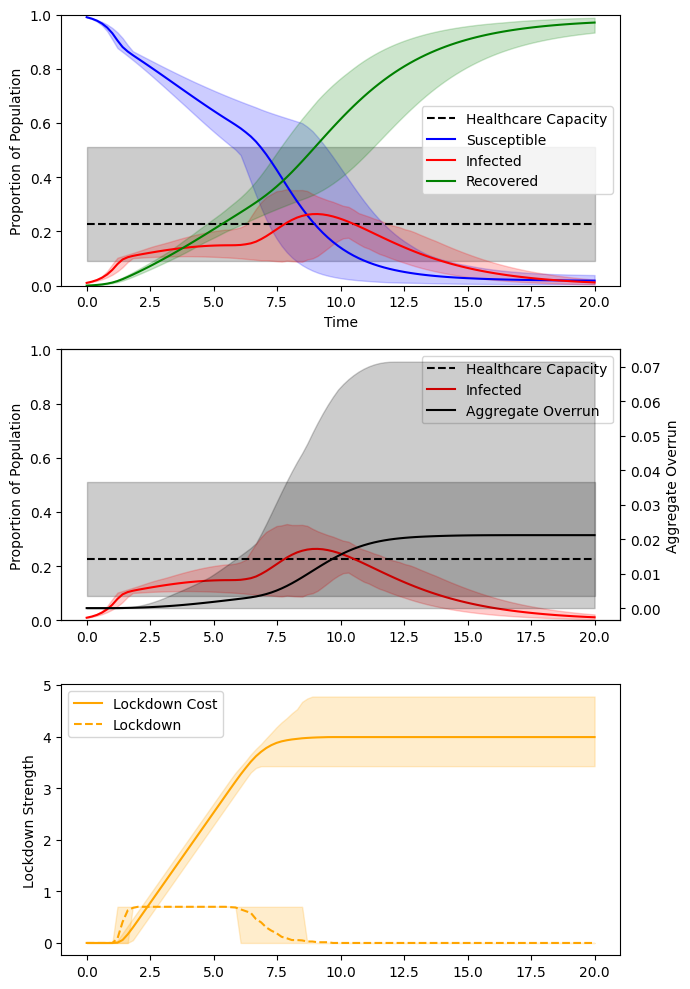

In [4]:
sri.plot_basic(
    dparams=DDP,
    stochastics=[pyro_prior_full() for _ in range(100)],
    init_state=DIS,
    timespan=DT,
    ci=0.9
)